In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report, confusion_matrix

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from pytorch_grad_cam import GradCAM

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')

In [4]:
ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed/test_GroundTruth2.csv')
ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed/train_GroundTruth2.csv')

In [5]:
mask_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/masks')
mask_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/masks')

In [6]:
train_ids = [f.stem for f in data_dir_train.glob("*.png")]
test_ids = [f.stem for f in data_dir_test.glob("*.png")]

In [7]:
#train_ids

In [8]:
class Dataset_skincancer_custom(Dataset):
    def __init__(self, image_dir, ground_truth_file, ids, mask_dir, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            ground truth: num
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.ground_truth_file = ground_truth_file
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.png").convert("RGB"))
        image = self.to_tensor(image)
        mask = np.array(Image.open(self.mask_dir / f"{name}_segmentation.png").convert("L"))
        mask = self.to_tensor(mask)
        
        # Load ground truth
        ground_truth_df = pd.read_csv(self.ground_truth_file)
        ground_truth = ground_truth_df[ground_truth_df['image_id'] == name][['melanoma', 'seborrheic_keratosis', 'none']].values
        ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
        ground_truth = ground_truth.squeeze()
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)
        
        #print(image)
        #print(ground_truth)

        return image, ground_truth, mask

In [9]:
batch_size = 16

In [10]:
# Create datasets with transformations
dataset_train = Dataset_skincancer_custom(data_dir_train, ground_truth_file_train, train_ids, mask_dir_train)
dataset_test = Dataset_skincancer_custom(data_dir_test, ground_truth_file_test, test_ids, mask_dir_test)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [11]:
for i, item in enumerate(test_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0706, 0.0784],
          [0.0314, 0.0196, 0.1529,  ..., 0.2392, 0.0627, 0.0784],
          [0.0275, 0.0314, 0.3412,  ..., 0.4392, 0.0863, 0.0706],
          ...,
          [0.3922, 0.3490, 0.3412,  ..., 0.4824, 0.4627, 0.4471],
          [0.3961, 0.3451, 0.3451,  ..., 0.5059, 0.4941, 0.4196],
          [0.2784, 0.3451, 0.3451,  ..., 0.4941, 0.4706, 0.2706]],

         [[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0745, 0.0824],
          [0.0314, 0.0196, 0.1412,  ..., 0.2314, 0.0627, 0.0784],
          [0.0314, 0.0314, 0.3137,  ..., 0.4235, 0.0863, 0.0706],
          ...,
          [0.3137, 0.2471, 0.2275,  ..., 0.4588, 0.4353, 0.4235],
          [0.3529, 0.2392, 0.2275,  ..., 0.4863, 0.4745, 0.4039],
          [0.2549, 0.2431, 0.2314,  ..., 0.4706, 0.4471, 0.2588]],

         [[0.0314, 0.0314, 0.0353,  ..., 0.1137, 0.0784, 0.0902],
          [0.0314, 0.0196, 0.1412,  ..., 0.2353, 0.0706, 0.0863],
          [0.0314, 0.0353, 0.3176,  ..., 

In [12]:
for i, item in enumerate(train_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.1098, 0.1333, 0.2275,  ..., 0.1686, 0.2078, 0.2980],
          [0.1176, 0.1373, 0.3725,  ..., 0.1804, 0.2392, 0.3294],
          [0.1059, 0.1961, 0.5020,  ..., 0.2157, 0.2196, 0.2745],
          ...,
          [0.4902, 0.4941, 0.5020,  ..., 0.1608, 0.1294, 0.1294],
          [0.4863, 0.4824, 0.4980,  ..., 0.1333, 0.1373, 0.1373],
          [0.4196, 0.4784, 0.4941,  ..., 0.1373, 0.1490, 0.1294]],

         [[0.1098, 0.1333, 0.2157,  ..., 0.1843, 0.2275, 0.3216],
          [0.1176, 0.1333, 0.3451,  ..., 0.2039, 0.2588, 0.3490],
          [0.1059, 0.1882, 0.4627,  ..., 0.2353, 0.2392, 0.3020],
          ...,
          [0.4510, 0.4510, 0.4667,  ..., 0.1608, 0.1255, 0.1333],
          [0.4510, 0.4392, 0.4588,  ..., 0.1373, 0.1373, 0.1373],
          [0.3922, 0.4392, 0.4510,  ..., 0.1412, 0.1490, 0.1294]],

         [[0.1176, 0.1412, 0.2196,  ..., 0.2353, 0.2863, 0.3804],
          [0.1255, 0.1451, 0.3412,  ..., 0.2667, 0.3137, 0.4118],
          [0.1137, 0.1961, 0.4588,  ..., 

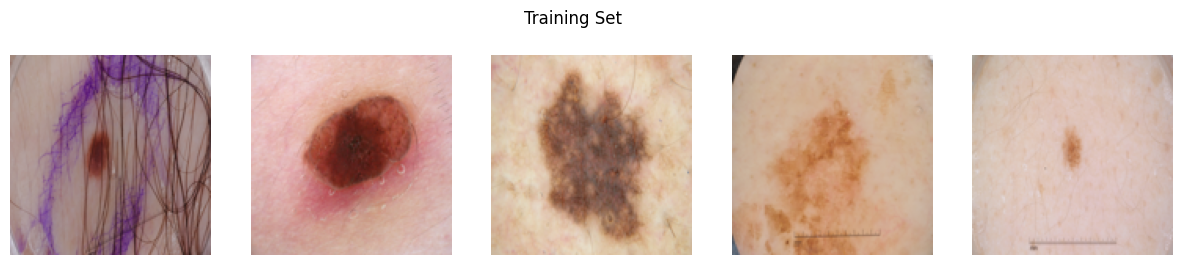

In [13]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, _, _) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
#plot_images(test_loader, "Test Set")

In [14]:
# create a custom convolutional neural network model for the classification task

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(192)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(384)
        self.relu3 = torch.nn.LeakyReLU()

        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.relu4 = torch.nn.LeakyReLU()

        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.relu5 = torch.nn.LeakyReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(256 * 3 * 3, 512)
        self.relu6 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.5)

        self.fc2 = torch.nn.Linear(512, 256)
        self.relu7 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.3)

        self.fc3 = torch.nn.Linear(256, 3)
        #self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.pool3(self.relu5(self.bn5(self.conv5(x))))
        
        x = self.flatten(x)

        x = self.relu6(self.fc1(x))
        x = self.dropout1(x)

        x = self.relu7(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x
    
# create model
model = CustomCNN().to(device)
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyRe

In [15]:
# test model with a random input
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[ 0.1004,  0.0376, -0.2247]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [16]:
# test model with the first batch of the training data
for i, (image, ground_truth, _) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    ground_truth = ground_truth.to(device)
    output = model(image)
    # convert output to tensor with 1 on the predicted class and 0 on the other classes
    _, predicted_max = torch.max(output, 1)
    print(output)
    output = torch.zeros_like(output)
    output[torch.arange(output.size(0)), predicted_max] = 1
    print(output)
    print(ground_truth)
    print(ground_truth.shape)

tensor([[ 0.2854,  0.0271, -0.2083],
        [-0.0664, -0.4823, -0.2183],
        [ 0.2664, -0.2010, -0.0293],
        [ 0.2260, -0.0702, -0.0839],
        [ 0.1867, -0.1653, -0.0993],
        [ 0.1200, -0.3522, -0.1994],
        [ 0.2915, -0.0649, -0.0597],
        [ 0.3625, -0.3093, -0.2807],
        [ 0.0988, -0.2250, -0.3012],
        [ 0.2373, -0.1347, -0.1741],
        [-0.0184,  0.1743,  0.1898],
        [ 0.4316, -0.1802, -0.0288],
        [-0.0772,  0.1170, -0.5129],
        [-0.0768, -0.1090, -0.0532],
        [ 0.2083, -0.2482, -0.0889],
        [-0.0286, -0.1948, -0.1777]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]], devi

In [17]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 3)  # Change final layer for 3-class classification
model = model.to(device)

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.tensor([(2000/374), (2000/254), (2000/1372)], device=device)) #

# train the model
accumulation_steps = 4
model.train()
for epoch in range(5):
    #if epoch == 1:
    #    break
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = len(train_loader)

    optimizer.zero_grad()

    for i, (images, ground_truth, _) in enumerate(train_loader):
        images, ground_truth = images.to(device), ground_truth.to(device)
        #ground_truth = ground_truth.float()
        
        outputs = model(images)
        #loss = criterion(outputs, ground_truth)
        loss = criterion(outputs, ground_truth.argmax(dim=1))#(((outputs - ground_truth)* tensor_weights)**2).mean()
        #print("outputs")
        #print(outputs)

        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        predictions = torch.argmax(outputs, dim=1)
        #print("predictions")
        #print(predictions)
        #print("ground_truth")
        #print(ground_truth)

        #optimizer.step()
        
        accuracy = (predictions == ground_truth.argmax(dim=1)).float().mean()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss/num_batches}, Accuracy: {epoch_accuracy/num_batches}")

Epoch 1, Loss: 1.0428204278945923, Accuracy: 0.534
Epoch 2, Loss: 0.7275586113929748, Accuracy: 0.7645
Epoch 3, Loss: 0.605632086277008, Accuracy: 0.887
Epoch 4, Loss: 0.5330651454925537, Accuracy: 0.9485
Epoch 5, Loss: 0.5138580284118652, Accuracy: 0.9705


In [19]:
# evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for images, ground_truth, _ in test_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        prediction_list = [0, 0, 0]
        prediction_list[predicted.cpu().numpy()[0]] = 1
        predictions.append(prediction_list)

In [20]:
df_predicted = pd.DataFrame(predictions, columns=['melanoma', 'seborrheic_keratosis','none'], index=test_ids)
df_predicted = df_predicted.sort_index()
df_predicted

,melanoma,seborrheic_keratosis,none
ISIC_0012086,0,1,0
ISIC_0012092,0,0,1
ISIC_0012095,0,0,1
ISIC_0012134,0,1,0
ISIC_0012136,0,1,0
...,...,...,...
ISIC_0016068,1,0,0
ISIC_0016069,0,0,1
ISIC_0016070,0,0,1
ISIC_0016071,0,0,1


In [21]:
df_predicted.sum()

melanoma                115
seborrheic_keratosis    194
none                    291
dtype: int64

In [22]:
df_ground_truth = pd.read_csv(ground_truth_file_test, index_col='image_id')
df_ground_truth

,melanoma,seborrheic_keratosis,none
image_id,,,
ISIC_0012086,0.0,1.0,0.0
ISIC_0012092,0.0,0.0,1.0
ISIC_0012095,0.0,0.0,1.0
ISIC_0012134,0.0,1.0,0.0
ISIC_0012136,0.0,1.0,0.0
...,...,...,...
ISIC_0016068,0.0,0.0,1.0
ISIC_0016069,0.0,0.0,1.0
ISIC_0016070,0.0,0.0,1.0


In [23]:
df_ground_truth.sum()

melanoma                117.0
seborrheic_keratosis     90.0
none                    393.0
dtype: float64

In [24]:
# print mean absolute error
print("Mean Absolute Error:")
print((df_predicted - df_ground_truth).abs().mean())

Mean Absolute Error:
melanoma                0.213333
seborrheic_keratosis    0.216667
none                    0.286667
dtype: float64


In [25]:
labels_predicted = df_predicted[['melanoma', 'seborrheic_keratosis', 'none']].idxmax(axis=1)
labels_ground_truth = df_ground_truth[['melanoma', 'seborrheic_keratosis', 'none']].idxmax(axis=1)

In [26]:
labels_predicted

ISIC_0012086    seborrheic_keratosis
ISIC_0012092                    none
ISIC_0012095                    none
ISIC_0012134    seborrheic_keratosis
ISIC_0012136    seborrheic_keratosis
                        ...         
ISIC_0016068                melanoma
ISIC_0016069                    none
ISIC_0016070                    none
ISIC_0016071                    none
ISIC_0016072                melanoma
Length: 600, dtype: object

In [27]:
labels_ground_truth

image_id
ISIC_0012086    seborrheic_keratosis
ISIC_0012092                    none
ISIC_0012095                    none
ISIC_0012134    seborrheic_keratosis
ISIC_0012136    seborrheic_keratosis
                        ...         
ISIC_0016068                    none
ISIC_0016069                    none
ISIC_0016070                    none
ISIC_0016071                    none
ISIC_0016072                    none
Length: 600, dtype: object

In [28]:
# evaluate the model
print("Classification Report")
print(classification_report(labels_ground_truth, labels_predicted))

Classification Report
                      precision    recall  f1-score   support

            melanoma       0.45      0.44      0.45       117
                none       0.88      0.65      0.75       393
seborrheic_keratosis       0.40      0.86      0.54        90

            accuracy                           0.64       600
           macro avg       0.58      0.65      0.58       600
        weighted avg       0.72      0.64      0.66       600



In [29]:
cm = confusion_matrix(labels_ground_truth, labels_predicted)
cm

array([[ 52,  26,  39],
       [ 59, 256,  78],
       [  4,   9,  77]])

In [30]:
import plotly.express as px
# plot confusion matrix
fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=['Melanoma', 'None', 'Seborrheic Keratosis'],
                 y=['Melanoma', 'None', 'Seborrheic Keratosis'], text_auto=True, width=600, height=600, color_continuous_scale='reds',
                   title="Confusion Matrix")
# remove colorbar
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [31]:
# save the model
#torch.save(model.state_dict(), "customCNN_new_skincancer_3classes_upgraded.pth")

---